# **Homework 0: Introduction to Isaac Environment**


**Member**
- Pavaris Asawakijtananont 65340500037
- Natnasa Lertmahakul 65340500021

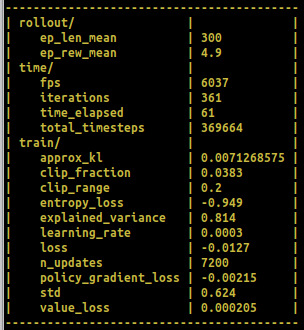

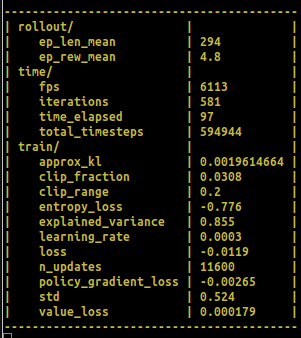

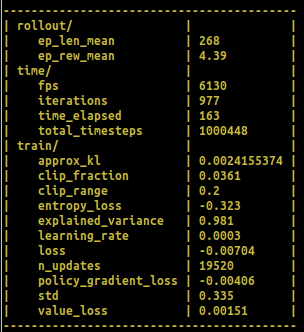

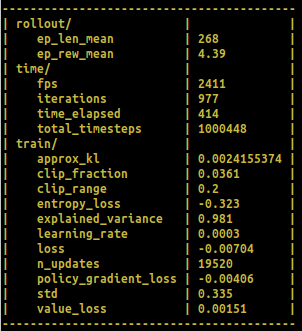

## **Part 1: Take a Look at Cartpole Rl Agent**

**Questions**
*Submit the answers to the following questions*:
1. According to the tutorials, if we want to edit the environment configuration, action space, observation space, reward function, or termination condition of the Isaac-Cartpole-v0 task, which file should we look at, and where is each part located?
2.  What are the action space and observation space for an agent defined in the Isaac-Cartpole-v0 task?
3.  How can episodes in the Isaac-Cartpole-v0 task be terminated?
4.  How many reward terms are used to train an agent in the Isaac-Cartpole-v0 task?


**Answer 1**

From running program according to the tutorials 

```
python source/standalone/workflows/sb3/train.py --task Isaac-Cartpole-v0 --num_envs 64 --headless --video --video_length 500 --video_interval 1000
```
We can known source program file for execute in IsaacLab folder, the execute program is name `train.py`